## 소리 감정분석 모델 03

In [19]:
import pandas as pd
import numpy as np
import json
import os

import pandas as pd
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv1D, MaxPooling1D, Flatten,  Dropout, BatchNormalization
import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
# import np_utils

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [21]:
json_path = 'E:/testData/Training/y/'
ls = []
for i in os.listdir(json_path):
    with open(json_path+i[:-5]+'.json', encoding='utf-8') as f:
        js= json.loads(f.read())
        for i in range(len(js['Conversation'])):
            ls.append(js['Conversation'][i]['VerifyEmotionTarget'])
set(ls)

{'기쁨', '놀라움', '사랑스러움', '없음', '화남'}

In [10]:
df_a = pd.read_csv('./train_list/final_Xtrain.csv')
df_a_val = pd.read_csv('./val_list/final_Xval.csv')
df_b = pd.read_csv('./train_list/final_ytrain.csv')
df_b_val = pd.read_csv('./val_list/final_yval.csv')

df_a = df_a.iloc[:,1:]
df_a_val = df_a_val.iloc[:,1:]
df_b = df_b.iloc[:,1:]
df_b_val = df_b_val.iloc[:,1:]

In [11]:
scaler = StandardScaler()

X_train_raw = np.array(df_a)
X_train_raw = scaler.fit_transform(X_train_raw)
X_train_raw = X_train_raw.reshape(X_train_raw.shape[0],X_train_raw.shape[1])
X_test_raw = np.array(df_a_val)
X_test_raw = scaler.transform(X_test_raw)
X_test_raw = X_test_raw.reshape(X_test_raw.shape[0],X_test_raw.shape[1],1)
y_train_raw = np.array(df_b)
y_train_raw = y_train_raw.reshape(y_train_raw.shape[0],y_train_raw.shape[1])
y_test_raw = np.array(df_b_val)
y_test_raw = y_test_raw.reshape(y_test_raw.shape[0],y_test_raw.shape[1],1)

In [12]:
def first_model(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(14,1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=7, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    #model.summary()
    return model

In [13]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001) #learning rate 조절 
modelpath = './model/model_{epoch:02d}-{val_accuracy:.4f}.h5'
mcp = ModelCheckpoint(
  filepath = modelpath,     #저장할 모델의 경로
  monitor = 'val_accuracy', #val_acc를 기준으로 전보다 모델이 나아지는 걸 확인
  save_best_only = True,    #나아진 결과만 저장
  verbose = 1               #과정을 출력
)

#전보다 나아지지 않으면 학습중단

es = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5      # 전보다 나아지지 않아도 실행할 횟수
)

In [14]:
#스케일링 - 데이터를 평균 0, 표준편차 1로 스케일을 축소

pre_trained_models = [
    # 'sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens',
# 'sentence-transformers/multi-qa-distilbert-cos-v1',
'jhgan/ko-sroberta-multitask',
# 'all-distilroberta-v1',
# 'jhgan/ko-sbert-multitask',
# 'all-MiniLM-L12-v2', 'jhgan/ko-sroberta-sts'
    ]


for i in pre_trained_models:
    X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_raw, random_state=0, stratify = y_train_raw, test_size = 0.3)


    # X_train = np.expand_dims(x_train, axis=2)
    # X_test = np.expand_dims(x_test, axis=2)
    X_train.shape, y_train.shape, X_test.shape, y_test.shape
    

    model = first_model(X_train)
    history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp,es,mcp])

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Pre-trained Model: ", i)
    print("Test Accuracy: ",test_acc)

Epoch 1/50
30696/30696 ━━━━━━━━━━━━━━━━━━━━ 412s 13ms/step - accuracy: 0.3659 - loss: 1.6400 - val_accuracy: 0.3750 - val_loss: 1.6247 - learning_rate: 0.0010
Epoch 2/50
30696/30696 ━━━━━━━━━━━━━━━━━━━━ 339s 11ms/step - accuracy: 0.3774 - loss: 1.6243 - val_accuracy: 0.3784 - val_loss: 1.6194 - learning_rate: 0.0010
Epoch 3/50
30696/30696 ━━━━━━━━━━━━━━━━━━━━ 325s 11ms/step - accuracy: 0.3794 - loss: 1.6216 - val_accuracy: 0.3801 - val_loss: 1.6185 - learning_rate: 0.0010
Epoch 4/50
30696/30696 ━━━━━━━━━━━━━━━━━━━━ 311s 10ms/step - accuracy: 0.3786 - loss: 1.6215 - val_accuracy: 0.3810 - val_loss: 1.6173 - learning_rate: 0.0010
Epoch 5/50
30696/30696 ━━━━━━━━━━━━━━━━━━━━ 310s 10ms/step - accuracy: 0.3798 - loss: 1.6200 - val_accuracy: 0.3801 - val_loss: 1.6185 - learning_rate: 0.0010
Epoch 6/50
30696/30696 ━━━━━━━━━━━━━━━━━━━━ 310s 10ms/step - accuracy: 0.3806 - loss: 1.6197 - val_accuracy: 0.3799 - val_loss: 1.6188 - learning_rate: 0.0010
Epoch 7/50
30696/30696 ━━━━━━━━━━━━━━━━━━━━ 31

KeyboardInterrupt: 

### Conformer로 검증

In [16]:
pip install conformer


   ---------------------------------------- 0.0/43.2 kB ? eta -:--:--
   ---------------------------------------- 43.2/43.2 kB 2.1 MB/s eta 0:00:00


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from conformer import Conformer

In [19]:
# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_raw, random_state=0, stratify = y_train_raw, test_size = 0.3)

In [22]:
# 하이퍼파라미터 설정
dim = 14 
num_classes = 7
depth = 6
heads = 8
ff_mult = 4
ff_dropout = 0.1

# Conformer 모델 정의
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conformer = Conformer(
            dim=dim,
            depth=depth, 
            heads=heads,
            ff_mult=ff_mult,
            ff_dropout=ff_dropout
        )
        self.classifier = nn.Linear(dim, num_classes)

    # def forward(self, x):
    #     x = self.conformer(x)
    #     x = self.classifier(x)
    #     return x
    def forward(self, x):
        x = self.conformer(x)
        x = self.classifier(x[:, 0, :])  # 첫 번째 시퀀스만 사용
        return x

# 데이터셋 클래스 정의
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X  # NumPy 배열
        self.y = y  # NumPy 배열 (원-핫 인코딩됨)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_vector = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0)  # 여기를 수정
        label = torch.tensor(self.y[idx], dtype=torch.float32)
        return input_vector, label


In [57]:
# 데이터 로더 정의
train_dataset = CustomDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 모델 인스턴스 생성 및 손실 함수, 옵티마이저 정의
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # 학습 history 저장을 위한 리스트
train_losses = []
val_losses = []

# 학습 루프
for epoch in range(2):
    train_losses_epoch = []
    val_losses_epoch = []
    # 학습 모드
    model.train()
    for inputs, labels in train_loader:
        # Forward 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 백프로패게이션
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        train_losses.append(loss.item())# history 

Epoch: 2, Train Loss: 1.6316, Val Loss: 1.6311
Epoch: 2, Train Loss: 1.6346, Val Loss: 1.6328


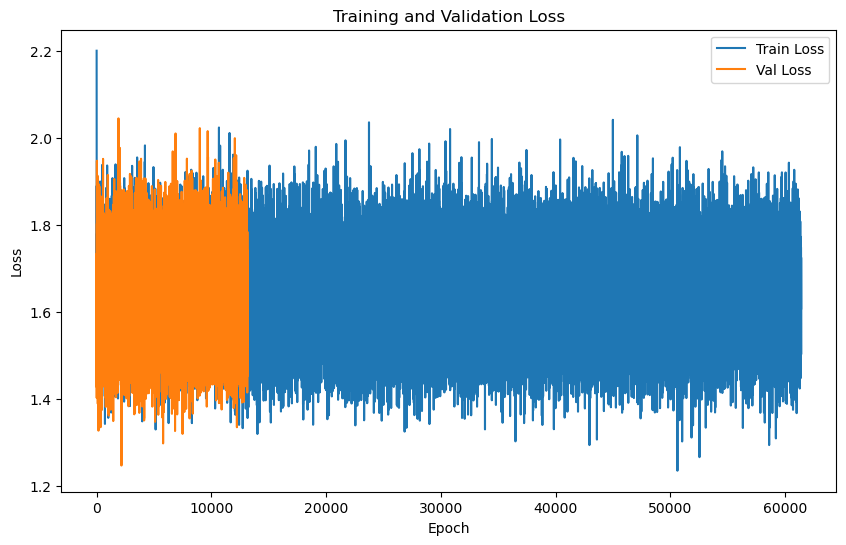

In [58]:
# 검증 모드


print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
# 검증 모드

val_dataset = CustomDataset(X_test, y_test)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_losses.append(loss.item())  # history 

train_loss = sum(train_losses) / len(train_losses)
val_loss = sum(val_losses) / len(val_losses)

 
print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [61]:
len(train_losses)

61392

In [62]:
len(val_losses)

13156

In [51]:
val_losses_epoch 

[1.6311060588441022, 1.6310996266076832]

### 텍스트 모델

In [6]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer"
Hint: = is not a valid operator. Did you mean == ?
'subdirectory'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [4]:
import KoBERT

ModuleNotFoundError: No module named 'KoBERT'

In [1]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

ModuleNotFoundError: No module named 'kobert'